In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, sys, numpy
sys.path.append('/home/dgotzens/scripts/')
import pdfdefaults as pdf
# setup
#pdf.setup()
nfft = 2**18

pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
refllocs = pickle.load(open(folder+'refl_params.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']


def r_est(R, theta0, exc, theta, K=len(tx)):
    txpos = torch.tensor([tx,ty,[-exc]*K])
    rxpos = torch.tensor([rx,ry,[-exc]*K])
    reflpos = (R-exc)*torch.stack([-torch.sin(theta-theta0),\
                            torch.zeros(len(theta)), \
                            torch.cos(theta-theta0)],0)

    return 0.5*torch.sqrt(((txpos[:,:,None]-reflpos[:,None,:])**2).sum(0))\
          + 0.5*torch.sqrt(((rxpos[:,:,None]-reflpos[:,None,:])**2).sum(0))

In [2]:
measurement = 'a'
results = []
for n, reflloc in enumerate(refllocs):
    R, theta0, exc = reflloc['dist'], reflloc['angle'], reflloc['excentricity']
    with open(f'{folder}{measurement}{int(R):02d}_angle.pkl', 'rb') as f:
        angle = torch.tensor(pickle.load(f))
    refldist = r_est(R,theta0,exc,angle)
    m_refl = ((refldist-int(R)-0.5)*bins_per_meter).long()
    fft = torch.load(f'{folder}{measurement}{int(R):02d}_bp_fft.pt')
    print(f'loaded data for {int(R)}m. processing...')
    M,K,L = fft.shape

    phase = numpy.empty((K,L))
    phase_peak = numpy.empty((K,L))
    for l in range(L):
        phase[:,l] = fft[m_refl[:,l], range(K), l].angle()
        m_peak = fft[:,:,l].abs().argmax(0)
        phase_peak[:,l] = fft[m_peak,range(K),l].angle()
    fft = None
    results.append((phase,phase_peak))
    print('processing complete.')

loaded data for 2m. processing...
processing complete.
loaded data for 8m. processing...
processing complete.
loaded data for 18m. processing...
processing complete.
loaded data for 32m. processing...
processing complete.


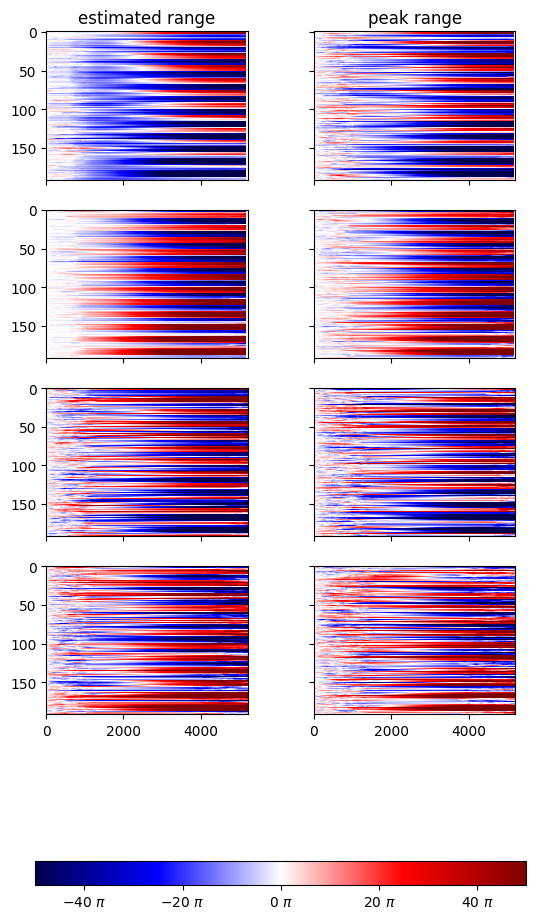

In [3]:
fig,axes = plt.subplots(4,2, sharex=True,sharey=True)
fig.set_size_inches(pdf.a4_textwidth, 2*pdf.a4_textwidth)

for n,(phase,phase_peak) in enumerate(results):
    (left,right) = axes[n,:]

    left.imshow(numpy.unwrap(phase)/pi, cmap='seismic', vmin=-50, vmax=50, aspect=20)
    im=right.imshow(numpy.unwrap(phase_peak)/pi, cmap='seismic', vmin=-50, vmax=50, aspect=20)
    if n==0:
        left.set_title('estimated range')
        right.set_title('peak range')

fig.colorbar(im,ax=axes.ravel(), orientation='horizontal', format=EngFormatter(r'$\pi$'))

In [4]:
pdf.setup()
fig,axes = plt.subplots(2,2, sharey=True)
fig.set_size_inches(0.95*pdf.a4_textwidth, 1.3*pdf.a4_textwidth)

for n,((phase,phase_peak),ax) in enumerate(zip(results,axes.flat)):
    R, theta0, exc = refllocs[n]['dist'], refllocs[n]['angle'], refllocs[n]['excentricity']
    with open(f'{folder}{measurement}{int(R):02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)
    estimate = 2*pi*f_start * 2*r_est(R,theta0,exc, torch.tensor(angle)) / lightspeed
    
    deg = torch.tensor([180/pi*(a-theta0) for a in angle])
    l_zero = deg.abs().argmin()
    for k, col in zip((12,99,183), ('tab:blue', 'tab:orange', 'tab:green')):
        rangemeas = numpy.unwrap(phase[k,:])/pi
        rangemeas -= 2*int(0.5*rangemeas[l_zero])

        peakmeas = numpy.unwrap(phase_peak[k,:])/pi
        peakmeas -= 2*int(0.5*peakmeas[l_zero])

        est = numpy.unwrap(estimate[k,:])/pi
        est -= 2*int(0.5*est[l_zero])

        ax.plot(deg, est, ':', c=col, label=f'{k=}' + (', signal model' if k==12 else ''))
        ax.plot(deg, peakmeas, '-.', c=col, label=f'{k=}' + (', phase at peak' if k==12 else ''))
        ax.plot(deg, rangemeas, '-',c=col, linewidth=0.5, label=f'{k=}' + (', phase at range estimate' if k==12 else ''))
    ax.grid()
    ax.set_ylim(-50,50)
    ax.set_xlim(-70,70)
    ax.xaxis.set_major_formatter(EngFormatter('°'))
    ax.yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
    ax.set_title(f'$\\hat R= {R:.3f}$m')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
fig.savefig('/home/dgotzens/thesis/figures/phase_estimates.pdf')
